# install the needed libraries

In [1]:
!pip -q install pyddm pandas matplotlib numpy scipy tqdm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyddm
import pyddm.plot
from scipy.stats import ttest_rel
from tqdm import tqdm

# load data

In [3]:
df_raw = pd.read_csv("dataset-9.tsv", sep="\t")
print(len(df_raw))
df_raw.head()

5520


,subjects,S,age,R,rt
0,1,right,age17,right,0.422023
1,1,left,age17,left,0.590425
2,1,left,age17,right,0.430260
3,1,right,age17,left,0.478868
4,1,left,age17,right,0.366551


# plot the reaction times

whole dataset

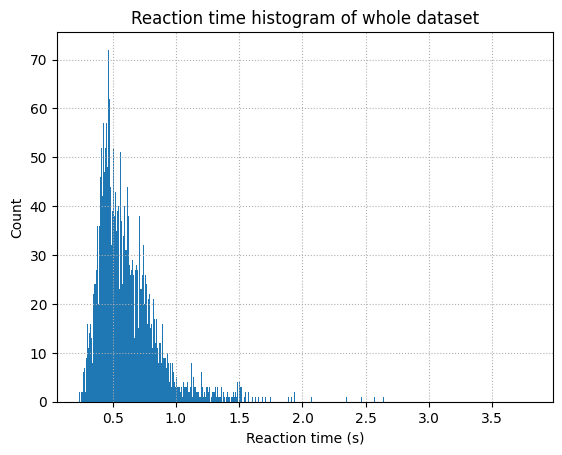

In [4]:
# histogram of whole dataset
plt.grid(True, linestyle=":")
plt.hist(df_raw["rt"], bins=1000)
plt.title("Reaction time histogram of whole dataset")
plt.xlabel("Reaction time (s)")
plt.ylabel("Count")
plt.show()

dataset without outliers

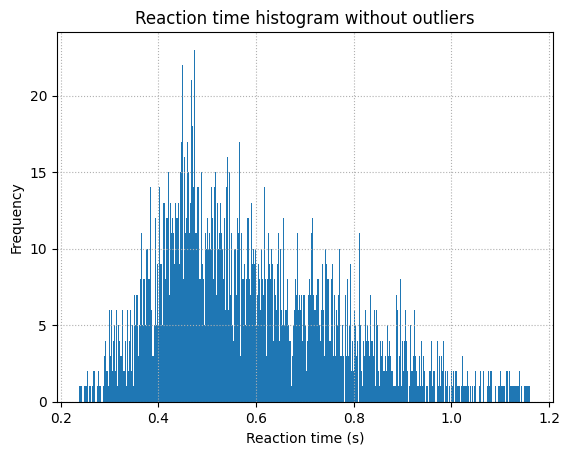

In [5]:
# histogram without outliers
# filter out the outliers based on the interquartile range
Q1, Q3 = df_raw["rt"].quantile([0.25, 0.75])
IQR = Q3 - Q1
df = df_raw[(df_raw["rt"] > Q1 - 1.5*IQR) & (df_raw["rt"] < Q3 + 1.5*IQR)].copy()

plt.grid(True, linestyle=":")
plt.hist(df["rt"], bins=1000)
plt.title("Reaction time histogram without outliers")
plt.xlabel("Reaction time (s)")
plt.ylabel("Frequency")
plt.show()

In [6]:
# create a new column that stores if the response was correct
df["correct"] = df["S"] == df["R"]
# split data into the two age groups
df_17 = df[df["age"] == "age17"]
df_25 = df[df["age"] == "age25"]
df.head()

,subjects,S,age,R,rt,correct
0,1,right,age17,right,0.422023,True
1,1,left,age17,left,0.590425,True
2,1,left,age17,right,0.430260,False
3,1,right,age17,left,0.478868,False
4,1,left,age17,right,0.366551,False


# histogram and density plot of the data for ages 17 an 25

histogram

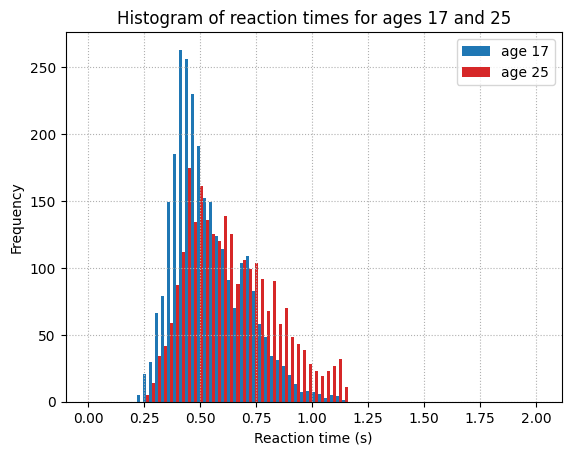

In [7]:
# histogram of the reaction times for the different age groups
plt.grid(True, linestyle=":")
# define how the bins will look
bins = np.linspace(0, 2, 75)
bar_width = (bins[1] - bins[0]) / 2

# Plot the histograms
plt.hist(
    df_17["rt"], bins=bins, label="age 17", width=bar_width,
    color="tab:blue"
    )
plt.hist(
    df_25["rt"], bins=bins + bar_width, label="age 25", width=bar_width,
    color="tab:red"
    )

plt.legend()
plt.title("Histogram of reaction times for ages 17 and 25")
plt.xlabel("Reaction time (s)")
plt.ylabel("Frequency")
plt.show()

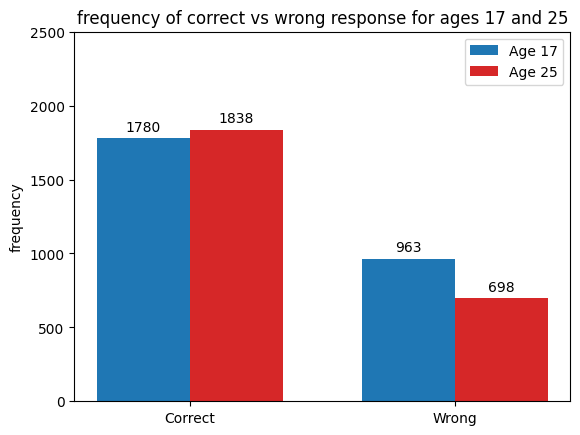

In [8]:
# plot the frequency of correct and wrong responses for the different age groups
# The possible outcomes
bars = ("Correct", "Wrong")
# The amount of correct and wrong answers per age
ages = {
    'Age 17': [df_17["correct"].sum(), len(df_17[df_17["correct"] == False])],
    'Age 25': [df_25["correct"].sum(), len(df_25[df_25["correct"] == False])]
}

x = np.arange(len(bars))
width = 0.35
multiplier = 0

for age, frequency in ages.items():
    color = "tab:blue" if age == "Age 17" else "tab:red"
    offset = width * multiplier
    rects = plt.bar(x + offset, frequency, width, label=age, color=color)
    plt.bar_label(rects, padding=3)
    multiplier += 1

plt.ylabel('frequency')
plt.title('frequency of correct vs wrong response for ages 17 and 25')
plt.xticks(x + width/2, bars)
plt.legend()
plt.ylim(0, 2500)

plt.show()

density plot

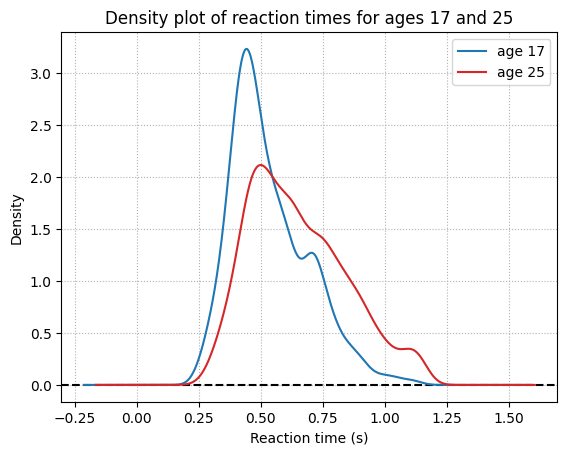

In [9]:
# density plot of the reaciton times for the different age groups
plt.axhline(0, color="black", linestyle="--")
df_17["rt"].plot.density(color="tab:blue", label="age 17")
df_25["rt"].plot.density(color="tab:red", label="age 25")
plt.grid(True, linestyle=":")
plt.legend()
plt.title("Density plot of reaction times for ages 17 and 25")
plt.xlabel("Reaction time (s)")
plt.show()

# histogram plotting means of reaction times and correct responses

In [10]:
# function to plot the significance line where needed
def plot_significance(p_value: np.float64, means: list[np.float64], stds: list[np.float64]) -> None:
    if p_value <= 0.001:
        significance = "***"
    elif p_value <= 0.01:
        significance = "**"
    elif p_value <= 0.05:
        significance = "*"
    else:
        significance = ""
    
    if not significance:
        return

    tips = np.max(np.add(means, stds))
    tips += tips/25
    height = tips + tips/50

    plt.plot(
        [0, 0, 1, 1],
        [tips, height, height, tips],
        color="black",
    )
    
    plt.text(
        0.5 - (0.02 * len(significance)),
        height + tips/100, significance,
        color="black",
    )

reaction time

pvalue: 2.3939393742542032e-05
[np.float64(0.5361733201150742), np.float64(0.6535801424091109)]
[np.float64(0.09588832686465891), np.float64(0.08951372266383542)]


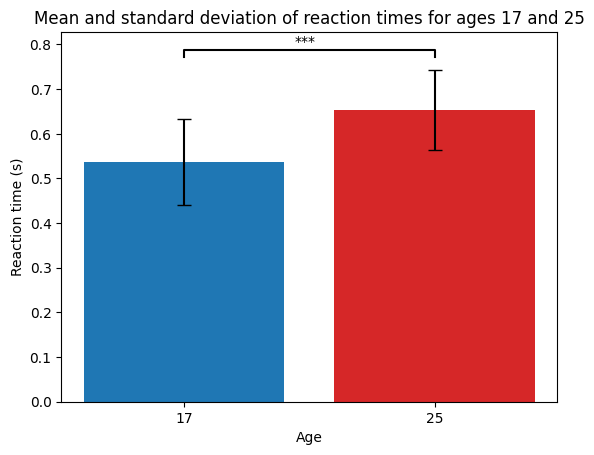

In [11]:
# t-test on the reaction time
cond1 = [df_17[df_17["subjects"] == subject]["rt"].mean() for subject in df_17["subjects"].unique()]
cond2 = [df_25[df_25["subjects"] == subject]["rt"].mean() for subject in df_25["subjects"].unique()]

p_value = ttest_rel(cond1, cond2).pvalue
print(f"pvalue: {p_value}")

rt_means = [np.mean(cond1), np.mean(cond2)]
rt_stds = [np.std(cond1), np.std(cond2)]

print(rt_means)
print(rt_stds)

plt.bar(["17", "25"], rt_means, yerr=rt_stds, color=["tab:blue", "tab:red"], capsize=5)
# plot the significance line if the p_value is low enough
plot_significance(p_value, rt_means, rt_stds)

plt.title("Mean and standard deviation of reaction times for ages 17 and 25")
plt.xlabel("Age")
plt.ylabel("Reaction time (s)")
plt.show()

correct response probability

pvalue: 2.7844134999647786e-05
[np.float64(0.6491444224015627), np.float64(0.728528294258388)]
[np.float64(0.08548367259182868), np.float64(0.08922322985943833)]


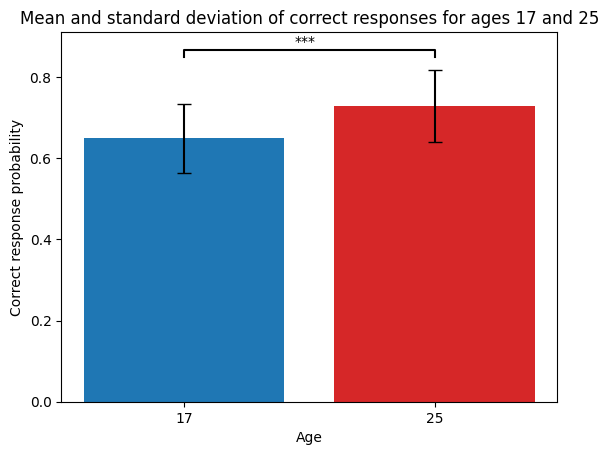

In [12]:
# t-test on the accuracy
cond1 = [df_17[df_17["subjects"] == subject]["correct"].mean() for subject in df_17["subjects"].unique()]
cond2 = [df_25[df_25["subjects"] == subject]["correct"].mean() for subject in df_25["subjects"].unique()]

p_value = ttest_rel(cond1, cond2).pvalue
print(f"pvalue: {p_value}")

correct_means = [np.mean(cond1), np.mean(cond2)]
correct_stds = [np.std(cond1), np.std(cond2)]

print(correct_means)
print(correct_stds)

plt.bar(["17", "25"], correct_means, yerr=correct_stds, color=["tab:blue", "tab:red"], capsize=5)
# plot the significance line if the p_value is low enough
plot_significance(p_value, correct_means, correct_stds)

plt.title("Mean and standard deviation of correct responses for ages 17 and 25")
plt.xlabel("Age")
plt.ylabel("Correct response probability")
plt.show()

# fit model on ages 17 and 25

class to determine the initial condition

In [13]:
class ICPointSideBias(pyddm.InitialCondition):
    name = "A starting point with a left or right bias."
    required_parameters = ["x0"]
    required_conditions = ["S"]
    def get_IC(self, x, dx, conditions):
        start = np.round(self.x0/dx)
        # Positive bias for right, negative for left
        if conditions["S"] == "left":
            start = -start
        shift_i = int(start + (len(x)-1)/2)
        assert shift_i >= 0 and shift_i < len(x), "Invalid initial conditions"
        pdf = np.zeros(len(x))
        pdf[shift_i] = 1.
        return pdf

plot the fitted model for ages 17 and 25

Info: Params [0.56917605 0.589084   0.22804336] gave 809.0262483014573


age 17:
{'drift': 0.5691760529958204, 'B': 0.589083998083287, 'nondectime': 0.22804336070113285}


Info: Params [0.78026997 0.67634281 0.26040492] gave 1179.5015204052327


age 25:
{'drift': 0.7802699720146075, 'B': 0.6763428085484503, 'nondectime': 0.2604049247746506}


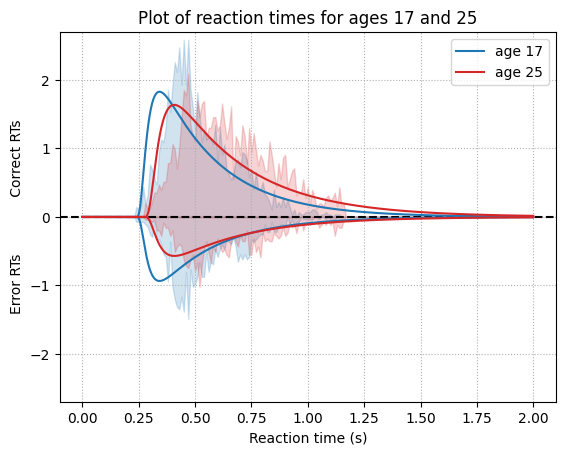

In [14]:
# age 17
m = pyddm.Model(
    drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
    bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=0.1, maxval=2)),
    overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)),
    dt=0.001,
    )

sample = pyddm.Sample.from_pandas_dataframe(df_17, rt_column_name="rt", choice_column_name="correct")
pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

print("age 17:")
# print the parameter names with their corresponding values
print({name: float(parameter) for name, parameter in zip(m.get_model_parameter_names(), m.get_model_parameters())})

plt.grid(True, linestyle=":")
plt.axhline(0, color="black", linestyle="--")
plt.plot(m.t_domain(), m.solve().pdf("correct"), color="tab:blue", label="age 17")
plt.plot(m.t_domain(), -1 * m.solve().pdf("error"), color="tab:blue")
plt.fill_between(
    sample.t_domain(), sample.pdf("correct"), color="tab:blue",
    alpha=0.2
    )
plt.fill_between(
    sample.t_domain(), -1 * sample.pdf("error"), color="tab:blue",
    alpha=0.2
    )

# age 25
m = pyddm.Model(
    drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
    bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=0.1, maxval=2)),
    overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)),
    dt=0.001,
    )

sample = pyddm.Sample.from_pandas_dataframe(df_25, rt_column_name="rt", choice_column_name="correct")
pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

print("age 25:")
# print the parameter names with their corresponding values
print({name: float(parameter) for name, parameter in zip(m.get_model_parameter_names(), m.get_model_parameters())})

plt.plot(m.t_domain(), m.solve().pdf("correct"), color="tab:red", label="age 25")
plt.plot(m.t_domain(), -1 * m.solve().pdf("error"), color="tab:red")
plt.fill_between(
    sample.t_domain(), sample.pdf("correct"), color="tab:red",
    alpha=0.2
    )
plt.fill_between(
    sample.t_domain(), -1 * sample.pdf("error"), color="tab:red",
    alpha=0.2
    )

# plot
plt.ylim(-2.7, 2.7)
plt.legend()
plt.title("Plot of reaction times for ages 17 and 25")
plt.xlabel("Reaction time (s)")
plt.ylabel("Error RTs             Correct RTs")
plt.show()

function to fit a model given the subject and age

In [15]:
def fit_model(subject: int, age: str) -> pyddm.model.Model:
    m = pyddm.Model(
        drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
        bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=0.1, maxval=2)),
        IC=ICPointSideBias(x0=pyddm.Fittable(minval=-.1, maxval=.1)),
        overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)),
        )
    sample = pyddm.Sample.from_pandas_dataframe(df[(df["subjects"] == subject) & (df["age"] == age)], rt_column_name="rt", choice_column_name="correct")
    pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

    return m

make dataframe of parameter values per condition per subject

In [16]:
# dataframe that will hold the parameter values per condition per subject
df_parameter_values = pd.DataFrame(columns=["subjects", "age", "drift", "B", "x0", "nondectime"])

# go over every subject
for subject in tqdm(df["subjects"].unique()):
    # go over every age
    for age in df["age"].unique():
        # fit a model
        m = fit_model(subject, age)
        # get the parameter names and values from the model and add them to the dataframe
        parameter_values = [subject, age] + [float(parameter) for parameter in m.get_model_parameters()]
        parameter_names = ["subjects", "age"] + m.get_model_parameter_names()
        df_parameter_values.loc[len(df_parameter_values)] = dict(zip(parameter_names, parameter_values))

df_parameter_values

  0%|          | 0/12 [00:00<?, ?it/s]Info: Params [ 0.6889101   0.50081606 -0.00771507  0.31636722] gave 25.757518580613215
Info: Params [ 0.95082166  0.6596576  -0.02264795  0.34198162] gave 74.77420735366039
  8%|▊         | 1/12 [00:12<02:16, 12.40s/it]Info: Params [ 0.54977293  0.3997444  -0.01084683  0.32945924] gave -54.37111411967894
Info: Params [0.78197543 0.56842203 0.00329283 0.34392198] gave 61.00991522369188
 17%|█▋        | 2/12 [00:24<02:04, 12.45s/it]Info: Params [0.98940789 0.37817883 0.01696408 0.42779406] gave -102.04364485008188
Info: Params [1.07952191 0.51621524 0.00687671 0.43823382] gave 9.937466117871836
 25%|██▌       | 3/12 [00:37<01:51, 12.41s/it]Info: Params [0.94800891 0.45951945 0.00526173 0.49890837] gave -73.18480418238255
Info: Params [ 1.13762858  0.54344149 -0.01068536  0.49931857] gave -20.58092902581184
 33%|███▎      | 4/12 [00:50<01:43, 12.90s/it]Info: Params [ 0.77559321  0.35033849 -0.01090516  0.38239875] gave -117.18488844264661
Info: Params

,subjects,age,drift,B,x0,nondectime
0,1,age17,0.688910,0.500816,-0.007715,0.316367
1,1,age25,0.950822,0.659658,-0.022648,0.341982
2,2,age17,0.549773,0.399744,-0.010847,0.329459
3,2,age25,0.781975,0.568422,0.003293,0.343922
4,3,age17,0.989408,0.378179,0.016964,0.427794
5,3,age25,1.079522,0.516215,0.006877,0.438234
6,4,age17,0.948009,0.459519,0.005262,0.498908
7,4,age25,1.137629,0.543441,-0.010685,0.499319
8,5,age17,0.775593,0.350338,-0.010905,0.382399
9,5,age25,0.731029,0.482990,0.025293,0.381440


# Create slope plots

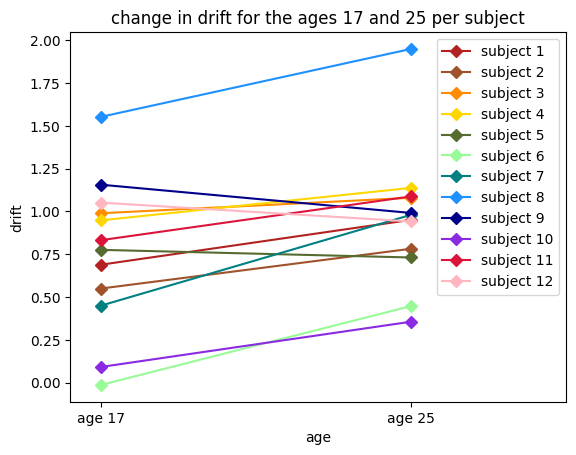

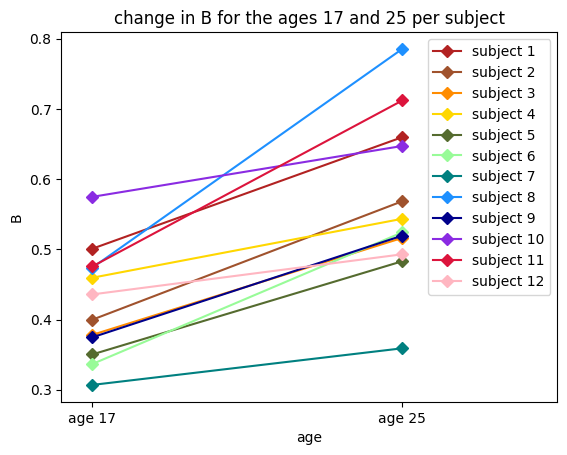

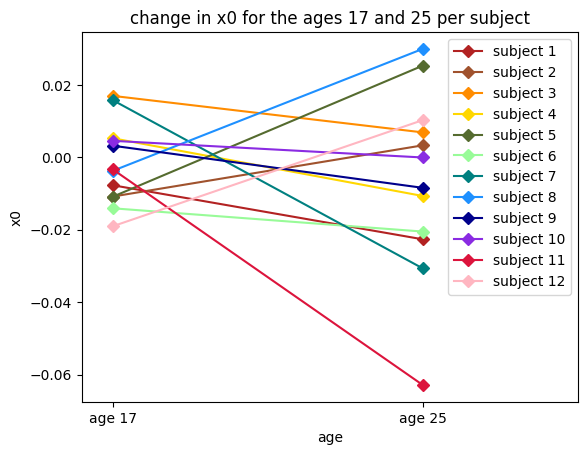

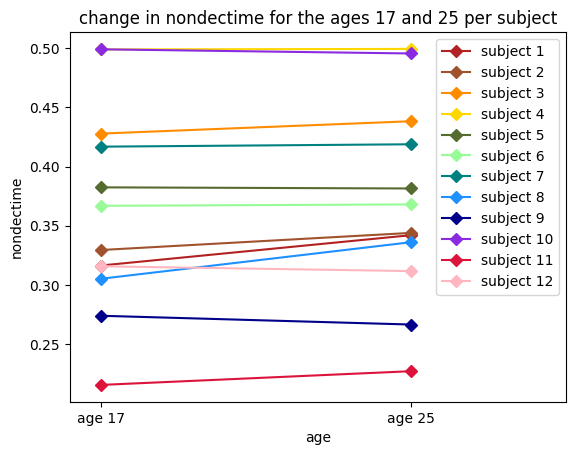

In [17]:
# slope plots visualizing the effects of the conditions on every parameter per subject
# define the colors per subject
colors = ["firebrick", "sienna", "darkorange", "gold", "darkolivegreen", "palegreen", "teal", "dodgerblue", "darkblue", "blueviolet", "crimson", "lightpink"]

# go over every parameter subject and condition
for param in ["drift", "B", "x0", "nondectime"]:
    for idx, subject in enumerate(df_parameter_values["subjects"].unique()):
        y = []
        for age in df_parameter_values["age"].unique():
            y.append(df_parameter_values[(df_parameter_values["subjects"] == subject) &
                                         (df_parameter_values["age"] == age)][param])
        plt.plot([0, 1], y, color=colors[idx], label=f"subject {subject}", marker="D")
    plt.xticks([0, 1], ["age 17", "age 25"])
    plt.legend()
    plt.xlim(-0.1, 1.5)
    plt.title(f"change in {param} for the ages 17 and 25 per subject")
    plt.ylabel(param)
    plt.xlabel("age")
    plt.show()

# paired t-test

function that performs a t-test on the two conditions given a parameter

In [18]:
def perform_t_test(parameter: str):
    # get the values for the two conditions
    cond1 = df_parameter_values[df_parameter_values["age"] == "age17"][parameter]
    cond2 = df_parameter_values[df_parameter_values["age"] == "age25"][parameter]

    p_value = ttest_rel(cond1, cond2).pvalue

    # calculate and print the t-value
    print(f"pvalue: {p_value}")

    means = [cond1.mean(), cond2.mean()]
    stds = [cond1.std(), cond2.std()]

    print(means)
    print(stds)

    # plot the mean and standard deviation
    plt.bar(["17", "25"], means, yerr=stds, color=["tab:blue", "tab:red"], capsize=5)
    # plot the significance line if the p_value is low enough
    plot_significance(p_value, means, stds)

    plt.title(f"Mean and standard deviation of {parameter} for ages 17 and 25")
    plt.xlabel("Age")
    plt.ylabel(parameter)
    plt.show()

drift:
pvalue: 0.009957846388857047
[np.float64(0.7560377764456558), np.float64(0.9527786030743296)]
[np.float64(0.4423832855247576), np.float64(0.39924751976287554)]


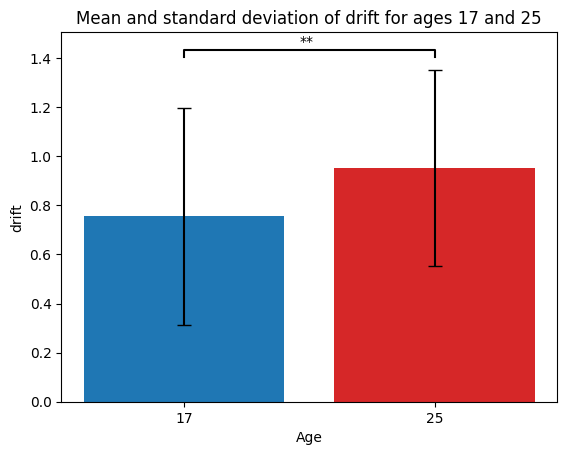


B:
pvalue: 3.9095840828297035e-05
[np.float64(0.42222016640249377), np.float64(0.5675406052020638)]
[np.float64(0.07804022379865279), np.float64(0.11546979729866588)]


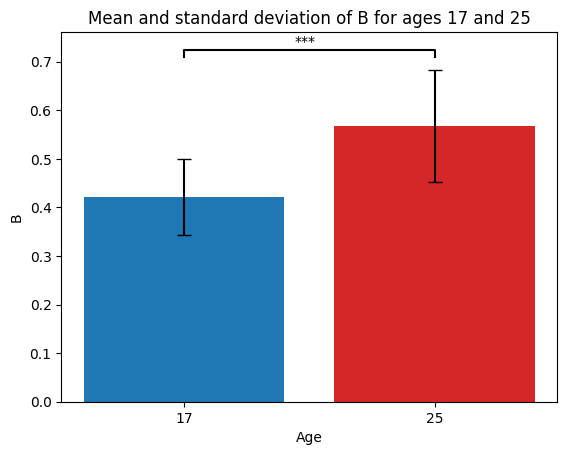


x0:
pvalue: 0.5953893169090421
[np.float64(-0.0019927496596565046), np.float64(-0.006685957568426391)]
[np.float64(0.011405988022207124), np.float64(0.025537787410547203)]


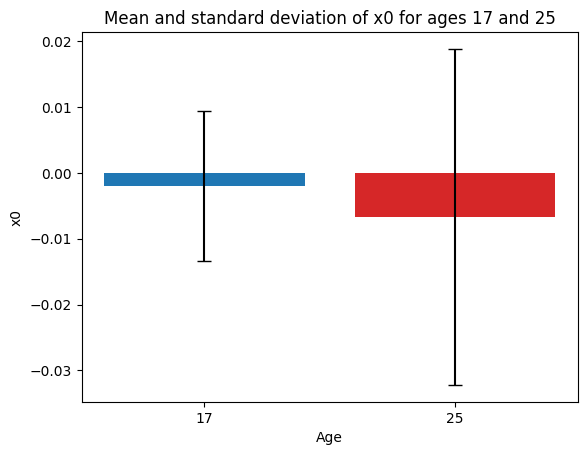


nondectime:
pvalue: 0.08058267181227646
[np.float64(0.3623198244536097), np.float64(0.369038168453754)]
[np.float64(0.08686524138620859), np.float64(0.08354374646283051)]


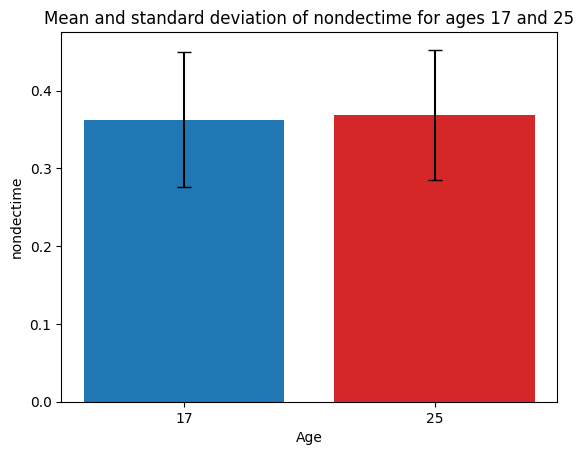

In [19]:
# perform the t-test on every parameter
for i in ["drift", "B", "x0", "nondectime"]:
    print(i + ":")
    perform_t_test(i)
    print()